# Applicant Online Tracking
### (Query Expansion with Word Embedding on GitHub Data)

The goal of this project is to use the information about developers, available on GitHub, and rank developers based on a search query applied by a recruiter. To solve this problem, we need to reformulate the search query to increase the accuracy of ranking problem. 

If we are wiling to apply the exact query on raw dataset, without any reformulation, the ranked result is limited to the matching exact tokens (words) in search queries with context exist per developer. However, the exact token may not occur in context related to a developer, but the developer still matches with the purpose of the search query. 

To solve this problem, we try to reformulate the search query based on a word embedding trained model. For example, suppose that we want to search for a “front end” developer. However, all developers who have experience in “front end” coding may not mention this keyword in their bio, but their contribution in different repositories may reflect their expertise. A word embedding algorithm helps us to find relevant words to “front end” and expand the search query with new list of similar words. 

After reformulating the search query, we use Best Matching 25 (BM25) algorithm to rank developers.

As a final step, we use the probability of developers' contribution in projects with different programming languages and add these probability as a weight into the scoring step and improve the accuracy of ranking problem.



#### Table of Content:
1. Dataset (**New: using tags in textual data**)
2. Data Cleaning
3. Train a Word Embedding: word2vec
4. Query Reformulation and Ranking Developers
5. Programming Languages (PL) Contribution (**New**)

   5.1. Link file extensions with PL name (**New**)
   
   5.2. Build a dataset of probability distribution from contributions (**New**)
   
   5.3. Update the ranking algorithm based on PL contributions (**New**)

**********************************************************************************
#### 1. Dataset

We collect a list of information about developers from GitHub. Dataset includes below fields for each developer:

**List of Fields:** _[name, account_url, email, location, Blog address, bio, Account creation date, Last Activity, Repository Name, Repository Languages, Number of commits per language in a repository (if it is a repository with more than one programming language), Repository stars, number of commits of users per repository and its language (file type), Repository Tags, Repository ReadMe file]_

Within all these fields, there are several textual fields that represent some information about the experience and the expertise domain of each developer: **bio**, **Repository Name**, **(new)Repository Tags**,**Repository ReadMe file**. In *bio*, developers use their title such as: front end developer, data scientist, etc. Not all developers fill this part with proper information (or they may leave it empty). However, the *“Name”*, *“Tags”* and the *“ReadMe file”* of those repositories that a developer contributed to them show additional information about her/his interest and experience.

We can consider the combination of these fields for each developer as a document that describe her/his expertise. To do so, we read raw data which is stored in pickle format and merge all these three fields as a new field named: **“textual_all”**. Also, we collect more fields per developer for further investigation. The final DataFrame contains below attributes, all type is string:

*columns=['Name','bio','Repository Name','ReadMe File','textual_all']*

The current raw dataset in pickle format is a sample data and contains the information of **33** developers.

In [1]:
import pickle
import os
import re
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument

C:\Users\morad\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
#the directory of pickle files
directory = r'C:\GH-Dataset\Git_dt_roles\users'

In [5]:
#Load files in pickle format. There is a seperate pickle file per each developer.
def open_file(file_path):
    with open(file_path, "rb") as picklefile:
        reader = pickle.load(picklefile)
    return(reader)

In [6]:
#Seprate lines in text with \n only (replace other newline tags with \n)
def newline(text):
    return '\n'.join([p for p in re.split(r'\\n|\\r|\\n\\n|\\r\\n|\r\n', text) if len(p) > 0])

In [7]:
#merge a list of readme files in a single string which are seperated with \n 
def merg_RM(RM):
    return '\n '.join(RM)

In [8]:
#merge to texts in one single text
def merg_text(txt1,txt2):
    return txt1 +"\n "+txt2

In [9]:
#define the final DataFrame format
Corpus = pd.DataFrame(columns=['Name','u_id','bio','Repo_Name','ReadMe','textual_all'])

In [10]:
#loop over all files in a directory and collect required fields
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    reader = open_file(file_path) 
    bio   = newline(str(reader['bio']))
    Name = str(reader['name'])
    try:
        u_id= str(reader['u_id'])
    except:
        u_id ="none"
        
    RM = []
    repo_name=[]
    repo_tags=[]
    repo_topics=[]
    repo_text=[]
    
    for row in range(0,len(reader['repository'])):
        repo_name_tmp = str(reader['repository'][row]['repo_name'])
        repo_RM_tmp = newline(str(reader['repository'][row]['readme']))
        repo_tags_tmp = str(reader['repository'][row]['topics'])
        repo_topics_tmp=newline(str(reader['repository'][row]['about']))
        
        repo_name.append(repo_name_tmp)
        RM.append(repo_RM_tmp)
        repo_tags.append(repo_tags_tmp)
        repo_topics.append(repo_topics_tmp)   
        
        repo_text_tmp = merg_text(merg_text(repo_tags_tmp,repo_topics_tmp),merg_text(repo_name_tmp,merg_text(bio,repo_RM_tmp)))
        repo_text.append(repo_text_tmp)
        
        
        
    text_all = merg_RM(repo_text) 
    info_all = merg_text(bio,text_all)
    
    
    Corpus = Corpus.append({'Name':Name,'u_id':u_id,'bio':bio,'Repo_Name':repo_name,'ReadMe':RM,
                            'textual_all':info_all},ignore_index=True)
    

In [11]:
dt1=Corpus[['u_id','textual_all']]

In [12]:
len(dt1)

1763

In [10]:
dt2 = pd.read_csv('C:\GH-Dataset\Git_dt_roles\git_data_single_label.csv')

In [71]:
len(dt2)

1460

In [19]:
dt_count_lb = dt2['label'].value_counts()

In [75]:
dt_count_lb

Frontend         598
Mobile           380
Backend          197
DataScientist    158
DevOps           127
Name: label, dtype: int64

In [77]:
#The accuracy of a naive classifier that predict everyone as a frontend
(598/1428)*100

41.87675070028011

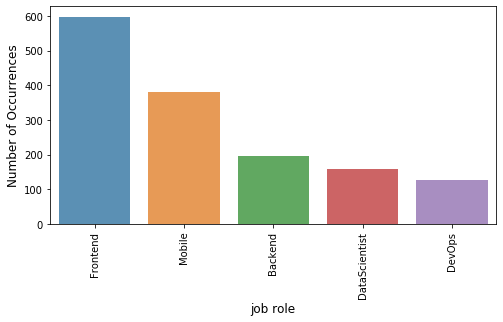

In [24]:
plt.figure(figsize=(8,4))
sns.barplot(dt_count_lb.index, dt_count_lb.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('job role', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [213]:
merged_inner = pd.merge(left=dt1, right=dt2[['gh_login','label']], left_on='u_id', right_on='gh_login')

In [214]:
txt_dt=merged_inner[['textual_all','label']]

In [215]:
txt_dt   

,textual_all,label
0,Passionate student learning web development.\n...,Frontend
1,An Ordinary Person Focusing On Python\n none\n...,Backend
2,Brian is a natural hands on technologist. This...,Frontend
3,IG(>_<)@54LiNKeR\n* Android Enthusiast(AE)\n* ...,Mobile
4,:bomb: F.zoomers!!.we?.boomers!!.let {it.go}\n...,Backend
...,...,...
1424,Trying to learn or develop something new every...,Mobile
1425,None\n none\n Учебный проект по основам Kotlin...,Backend
1426,Learning JavaScript for fun\n none\n Graduate ...,Frontend
1427,Student of Slovak Technical University faculty...,Backend


In [74]:
#number of words before cleaning
txt_dt['textual_all'].apply(lambda x: len(x.split(' '))).sum()

22774593

In [11]:
import gensim
from gensim.parsing.preprocessing import *

**********************************************************************************
#### 2. Data Cleaning
After merging bio, Repository Name and Repository ReadMe file in a single field, “textual_all”, we should clean the textual data. Data Cleaning includes below steps:

1. Split sentences in a text
2. tokenize each sentence in each text
3. remove stop words
4. seprate digits & letters such as BM25--> BM 25
5. remove digits
6. remove tags such as HTML tags
7. remove non alphabetic letters such as !,?,#
8. stemming tokens (transform into lowercase)
9. train a bigram model to extract phrases (two words as a single phrase) such as machine learning


In [79]:
#store the textual_all in a sperate varaible
documents=txt_dt['textual_all']

In [37]:
#documents[1]

In [12]:
#seperte sentences with \n
def split_sentence(corpus):
    sentences = [doc.split("\n") for doc in corpus]
    return sentences

In [13]:
#flat a list of lists into a list
def flatten_list(sentences):
    flatList = [ item for elem in sentences for item in elem]
    return flatList

In [14]:
#tokenize all sentences
def token_in_sentence(list_sentences):
    list_tokens = [list(gensim.utils.tokenize(doc, lower=True)) for doc in list_sentences]
    return list_tokens

In [15]:
#build a bundle of actions to clean data
def custom_filter():
    cstm_filter = [remove_stopwords,split_alphanum, strip_numeric, strip_tags, strip_non_alphanum,stem_text]
    return cstm_filter

In [16]:
#cleaning data based on steps define in custom_filter
def str_preprocessing(tokenize_sentence):
    CUSTOM_FILTERS = custom_filter()
    tokens_new = preprocess_string(" ".join(tokenize_sentence), CUSTOM_FILTERS)
    return tokens_new

In [17]:
#get the possible phrases in the list of tokens
def get_bigram_token(model,tokens):
    bigrams = model[tokens]
    bi_tokens= [sent for sent in bigrams]
    return bi_tokens

In [86]:
#split sentence in documents (Corpus['textual_all'])
sentences_stream = split_sentence(txt_dt['textual_all'])

In [87]:
len(sentences_stream)

1428

In [68]:
#tokenize all sentences
tokenize_sentence=[]
for row in sentences_stream:
    tokenize_st = flatten_list(token_in_sentence(row))
    tokenize_sentence.append(tokenize_st)

In [88]:
#cleaning data with costum actions
processing_tokens = [str_preprocessing(sen) for sen in sentences_stream]

In [70]:
clean_tokens=[]
for row in processing_tokens:
    clean_tokens.append([w for w in row if len(w)>2])
#clean_tokens = [w for t in processing_tokens for w in t if len(w) > 1]

In [91]:
#clean_tokens[10]

In [58]:
flatten_tokenize=flatten_list(tokens_bigram)

In [59]:
len(flatten_tokenize)

17761717

In [63]:
if "data_scientist" in flatten_tokenize:
    print("true")

true


In [92]:
#build a bigram model to collect phrases. The threshold equals to 2. 
#It means if two words accure in bigram more than 2 times, then we collect them as a single phrase
#The threshold is small becuase we are working on a sample dataset.
#After changing the sample dataset to real dataset, we should increase the threshold
#min_count: Ignore all words and bigrams with total collected count lower than this value. 5 , 10
#bigram_mdl = gensim.models.phrases.Phrases(tokenize_sentence, min_count=5, threshold=10)
bigram_mdl = gensim.models.phrases.Phrases(clean_tokens, min_count=10, threshold=15)

In [93]:
#Get the phrases in our corpus
tokens_bigram= get_bigram_token(bigram_mdl,clean_tokens)

In [440]:
#tokens_bigram includes 46 corpus, per each 46 developers in our sample dataset
#tokens_bigram[0]

In [94]:
#tokens_bigram[2]
len(tokens_bigram)

1428

In [95]:
tmp_df = {'text_all':tokens_bigram,'label':txt_dt['label']}

In [96]:
doc2vec_dt = pd.DataFrame(tmp_df)

In [97]:
doc2vec_dt

,text_all,label
0,"[passion, student, learn, web, develop, static...",Frontend
1,"[ordinari, person, focus, python, littl, game,...",Backend
2,"[brian, natur, hand, technologist, gift, unive...",Frontend
3,"[linker, android, enthusiast, mobil, develop, ...",Mobile
4,"[bomb_zoomer, boomer_let, octocat, speech_ball...",Backend
...,...,...
1423,"[try, learn, develop, new, everydai, address, ...",Mobile
1424,"[учебный, проект, основам, kotlin, otuskotlin,...",Backend
1425,"[learn, javascript, fun, graduat, project, htm...",Frontend
1426,"[student_slovak, technic, univers_faculti, inf...",Backend


In [99]:
train_tagged = doc2vec_dt.apply(
    lambda r: TaggedDocument(words=r['text_all'], tags=[r.label]), axis=1)

In [101]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [102]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)

In [103]:
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████████████████████████████████████████████████████████████████████| 1428/1428 [00:00<00:00, 481390.94it/s]


In [104]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|█████████████████████████████████████████████████████████████████████████| 1428/1428 [00:00<00:00, 1482174.24it/s]


Wall time: 3min 21s


In [106]:
train, test = train_test_split(train_tagged, test_size=0.3, random_state=42)

In [107]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [108]:
y_train, X_train = vec_for_learning(model_dbow, train)
y_test, X_test = vec_for_learning(model_dbow, test)

In [109]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\morad\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [110]:
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.317016317016317
Testing F1 score: 0.3318680255992614


In [111]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|█████████████████████████████████████████████████████████████████████████| 1428/1428 [00:00<00:00, 1431858.98it/s]


In [112]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████████████████████████████████████████████████████████████████████| 1428/1428 [00:00<00:00, 731403.85it/s]


Wall time: 6min 7s


In [153]:
y_train, X_train = vec_for_learning(model_dmm, train)
y_test, X_test = vec_for_learning(model_dmm, test)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('Percision: {}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {}'.format(recall_score(y_test, y_pred, average='weighted')))

C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy 0.8041958041958042
F1 score: 0.8054707115824861
Percision: 0.8114489284591462
Recall: 0.8041958041958042


In [114]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [18]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

NameError: name 'model_dbow' is not defined

In [118]:
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [119]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [154]:
y_train, X_train = get_vectors(new_model, train)
y_test, X_test = get_vectors(new_model, test)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('Percision: {}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {}'.format(recall_score(y_test, y_pred, average='weighted')))

C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy 0.8158508158508159
F1 score: 0.8180603648897228
Percision: 0.8254278644665968
Recall: 0.8158508158508159


### bag of words

In [19]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [205]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    print('Testing F1 score: {}'.format(f1_score(target, predictions, average='weighted')))
    print('percision: {}'.format(precision_score(target, predictions, average='weighted')))
    print('recall: {}'.format(recall_score(target, predictions, average='weighted')))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [21]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['textual_all'])
    predictions = classifier.predict(data_features)
    target = data['label']
    evaluate_prediction(predictions, target)

In [207]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [2]:
import nltk
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

In [24]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\morad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [216]:
train_data, test_data = train_test_split(txt_dt, test_size=0.1, random_state=42)

In [217]:
my_tags = txt_dt.label.unique()

In [218]:
%%time
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english')
train_data_features = tf_vect.fit_transform(train_data['textual_all'])

Wall time: 4min 20s


In [161]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 
train_data_features = count_vectorizer.fit_transform(train_data['textual_all'])

Wall time: 4min 28s


In [162]:
%%time

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['label'])

C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\morad\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Wall time: 12.4 s


In [220]:
###TFidf
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['label'])

C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.5384615384615384
Testing F1 score: 0.508303192187843
percision: 0.5124128653540418
percision: 0.5384615384615384
confusion matrix
 [[43  2  6  1  0]
 [ 7  0  4  2  3]
 [17  5 20  3  5]
 [ 1  0  1 11  1]
 [ 6  1  1  0  3]]
(row=expected, col=predicted)


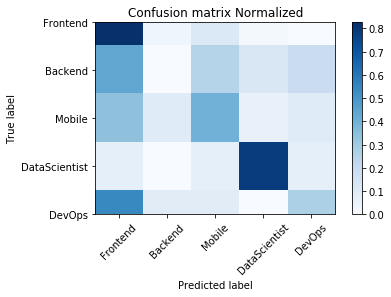

In [163]:
predict(count_vectorizer, logreg, test_data)

accuracy 0.5104895104895105
Testing F1 score: 0.501902973642104
percision: 0.5072981563890654
recall: 0.5104895104895105
confusion matrix
 [[34  7  8  2  0]
 [ 7  1  3  2  1]
 [17  4 18  3  5]
 [ 0  0  2 17  2]
 [ 2  2  2  1  3]]
(row=expected, col=predicted)


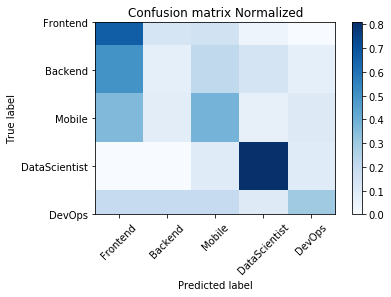

In [221]:
#predict ifidf
predict(tf_vect, logreg, test_data)

### Average WE

In [25]:
#define the final DataFrame format
Corpus = pd.DataFrame(columns=['Name','u_id','bio','Repo_Name','ReadMe','textual_all'])

In [26]:
#loop over all files in a directory and collect required fields
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    reader = open_file(file_path) 
    bio   = newline(str(reader['bio']))
    Name = str(reader['name'])
    try:
        u_id= str(reader['u_id'])
    except:
        u_id ="none"
        
    RM = []
    repo_name=[]
    repo_tags=[]
    repo_topics=[]
    repo_text=[]
    
    for row in range(0,len(reader['repository'])):
        repo_name_tmp = str(reader['repository'][row]['repo_name'])
        repo_RM_tmp = newline(str(reader['repository'][row]['readme']))
        repo_tags_tmp = str(reader['repository'][row]['topics'])
        repo_topics_tmp=newline(str(reader['repository'][row]['about']))
        
        #repo_name.append(repo_name_tmp)
        #RM.append(repo_RM_tmp)
        #repo_tags.append(repo_tags_tmp)
        #repo_topics.append(repo_topics_tmp)   
        
        repo_text_tmp = merg_text(merg_text(repo_tags_tmp,repo_topics_tmp),merg_text(repo_name_tmp,merg_text(bio,repo_RM_tmp)))
        Corpus = Corpus.append({'Name':Name,'u_id':u_id,'bio':bio,'Repo_Name':repo_name_tmp,'ReadMe':repo_RM_tmp,
                            'textual_all':repo_text_tmp},ignore_index=True)
        
        #repo_text.append(repo_text_tmp)
        
        
        
    #text_all = merg_RM(repo_text) 
   # info_all = merg_text(bio,text_all)
    
    
   # Corpus = Corpus.append({'Name':Name,'u_id':u_id,'bio':bio,'Repo_Name':repo_name,'ReadMe':RM,
                            #'textual_all':info_all},ignore_index=True)
    

In [27]:
len(Corpus)

58575

In [28]:
dt3=Corpus[['u_id','textual_all']]

In [29]:
merged_inner = pd.merge(left=dt3, right=dt2[['gh_login','label']], left_on='u_id', right_on='gh_login')

In [58]:
repo_txt_dt=merged_inner[['u_id','textual_all','label']]

In [60]:
repo_txt_dt.head()

,u_id,textual_all,label
0,0raclewind,none\n Static Web pages\n 0raclewind.github.io...,Frontend
1,0raclewind,none\n An enterprise social network\n bootcamp...,Frontend
2,0raclewind,none\n None\n cryptogram\n Passionate student ...,Frontend
3,0raclewind,none\n None\n CS50-repo\n Passionate student l...,Frontend
4,0raclewind,none\n None\n cs50w\n Passionate student learn...,Frontend


In [32]:
#split sentence in documents (Corpus['textual_all'])
repo_sentences_stream = split_sentence(repo_txt_dt['textual_all'])

In [33]:
#tokenize all sentences
repo_tokenize_sentence=[]
for row in repo_sentences_stream:
    tokenize_st = flatten_list(token_in_sentence(row))
    repo_tokenize_sentence.append(tokenize_st)

In [34]:
len(repo_tokenize_sentence)

47485

In [50]:
repo_processing_tokens_4 = [str_preprocessing(sen) for sen in repo_tokenize_sentence[40000:47485]]

In [51]:
len(repo_processing_tokens_4)

7485

In [52]:
repo_clean_tokens_4=[]
for row in repo_processing_tokens_4:
    repo_clean_tokens_4.append([w for w in row if len(w)>2])

In [53]:
repo_clean_tokens = repo_clean_tokens_1 + repo_clean_tokens_2 + repo_clean_tokens_3 + repo_clean_tokens_4

In [54]:
len(repo_clean_tokens)

47485

In [55]:
bigram_mdl = gensim.models.phrases.Phrases(repo_clean_tokens, min_count=10, threshold=15)

In [56]:
tokens_bigram= get_bigram_token(bigram_mdl,repo_clean_tokens)

In [57]:
len(tokens_bigram)

47485

In [62]:
repo_tmp_df = {'u_id':repo_txt_dt['u_id'],'text_all':tokens_bigram,'label':repo_txt_dt['label']}

In [64]:
repo_doc2vec_dt = pd.DataFrame(repo_tmp_df)

In [65]:
len(repo_doc2vec_dt)

47485

In [66]:
repo_doc2vec_dt

,u_id,text_all,label
0,0raclewind,"[static, web, page, raclewind, github, passion...",Frontend
1,0raclewind,"[enterpris, social_network, bootcamp, passion,...",Frontend
2,0raclewind,"[cryptogram, passion, student, learn, web, dev...",Frontend
3,0raclewind,"[repo, passion, student, learn, web, develop]",Frontend
4,0raclewind,"[passion, student, learn, web, develop]",Frontend
...,...,...,...
47480,zxl86,[monster_rolodex],Frontend
47481,zxl86,"[rsvp, rsvp, respons, rsvp, web, applic, enabl...",Frontend
47482,zxl86,"[todo, react, get_start, creat, react, app, pr...",Frontend
47483,zxl86,"[weather, widget, editor, run, project, mac, w...",Frontend


In [67]:
from gensim.models import word2vec

In [82]:
repo_w2v_model = word2vec.Word2Vec(tokens_bigram, size=200, window=50, min_count=5, workers=1)

In [101]:
repo_w2v_model.wv.most_similar('backend',topn=15)

[('lookup_demo', 0.5082775354385376),
 ('fullstackreact_food', 0.5082755088806152),
 ('frontend', 0.48573464155197144),
 ('rail_proxi', 0.4679315686225891),
 ('starandtina', 0.46289023756980896),
 ('www_fullstackreact', 0.46266674995422363),
 ('server_companion', 0.4430949091911316),
 ('tjenkin', 0.41589176654815674),
 ('solid_ethereum', 0.4039526879787445),
 ('programm_mainli', 0.4004155397415161),
 ('oneturkmen', 0.3850681781768799),
 ('companion', 0.38415881991386414),
 ('jokosu', 0.37050676345825195),
 ('gkal', 0.36648792028427124),
 ('thearena', 0.35989832878112793)]

In [85]:
repo_w2v_model.save("repo_word2vec_github.model")

In [103]:
def word_averaging(model, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in model.wv.vocab:
            mean.append(model.wv.syn0norm[model.wv.vocab[word].index])
            all_words.add(model.wv.vocab[word].index)

    if not mean:
        #print("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(model.layer1_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [105]:
len(repo_word_average)

47485

In [ ]:
train_data, test_data = train_test_split(repo_doc2vec_dt, test_size=0.1, random_state=42)

In [136]:
repo_word_average = word_averaging_list(repo_w2v_model,tokens_bigram)

C:\Users\morad\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  
C:\Users\morad\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `layer1_size` (Attribute will be removed in 4.0.0, use self.trainables.layer1_size instead).
  


In [137]:
repo_avg_df = {'u_id':repo_doc2vec_dt['u_id'],'text_all':repo_word_average.tolist(),'label':repo_doc2vec_dt['label']}

In [138]:
repo_avg_wv = pd.DataFrame(repo_avg_df)

In [159]:
def vector_average(group):
    series_to_array = np.array(group.tolist())
    return np.mean(series_to_array, axis = 0)

In [164]:
len(repo_avg_wv)

47485

In [173]:
dev_vec_avg=repo_avg_wv.groupby('u_id')['text_all'].apply(vector_average)

In [174]:
dev_vec_avg_df = pd.DataFrame(dev_vec_avg).reset_index()

In [175]:
dev_vec_avg_df

,u_id,text_all
0,0raclewind,"[0.06169216446578503, -0.03852514638565481, 0...."
1,1xuan,"[-0.002924589595446984, 0.059879501815885305, ..."
2,4mifix,"[-0.03759062166015307, -0.0072496456640591435,..."
3,54LiNKeR,"[0.023022594618781183, -0.047122604124104746, ..."
4,5aboteur,"[0.03262735875384686, -0.04721640296721537, 0...."
...,...,...
1400,zorrodg,"[-0.015871385467194375, -0.03629233078321531, ..."
1401,zundarik,"[0.014458707932915007, -0.08652578520455531, -..."
1402,zuni4ka,"[0.0018869513180106879, -0.0822878584265709, -..."
1403,zurek11,"[0.0631397199613275, -0.07552248747864117, 0.0..."


In [176]:
avg_merged_inner = pd.merge(left=dev_vec_avg_df, right=dt2[['gh_login','label']], left_on='u_id', right_on='gh_login')

In [178]:
avg_final_dt = avg_merged_inner[['text_all','label']]

In [184]:
len(avg_final_dt)

1405

In [179]:
train_data, test_data = train_test_split(avg_final_dt, test_size=0.1, random_state=42)

In [203]:
my_tags = avg_final_dt.label.unique()

In [197]:
avg_train = np.vstack([row for row in train_data['text_all'] ])

In [199]:
avg_test = np.vstack([row for row in test_data['text_all'] ])

In [198]:
%%time
repo_logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

repo_logreg = repo_logreg.fit(avg_train, train_data['label'])

C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Wall time: 897 ms


In [200]:
predicted = repo_logreg.predict(avg_test)

accuracy 0.5602836879432624
Testing F1 score: 0.547881564441179
percision: 0.5460181025690544
recall: 0.5602836879432624
confusion matrix
 [[36  3  4  2  4]
 [ 9  5  6  1  4]
 [ 8  2 24  4  2]
 [ 2  3  0 10  0]
 [ 2  2  3  1  4]]
(row=expected, col=predicted)


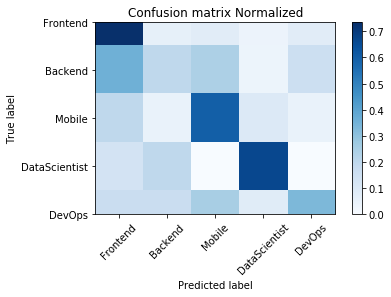

In [206]:
evaluate_prediction(predicted, test_data['label'])

******************************************************************************************
#### 3. Train a Word Embedding: word2vec
After cleaning dataset, we train a word2vec model based on the information available in tokens_bigram to find most similar or most related words for expanding the search query.

It is worth to mention that the current model is trained based on a sample data of 46 developers. Thus, it may not be a well trained model. To train a proper model, we need to feed more data into our model.

In [581]:
from gensim.models import word2vec

In [2400]:
#train word2vec model size=200, window=10, min_count=5, workers=1
w2v_model = word2vec.Word2Vec(clean_tokens, size=150, window=20, min_count=5, workers=1)

In [1931]:
w2v_model.save("word2vec_github.model")

In [2402]:
w2v_model.wv.most_similar('backend',topn=15)

[('starandtina', 0.7072836756706238),
 ('frontend', 0.5120173692703247),
 ('time_tracker_frontend', 0.45711833238601685),
 ('recruityourninja', 0.4426824450492859),
 ('thearena', 0.4343031644821167),
 ('yummli', 0.4327368438243866),
 ('fluxi', 0.43104884028434753),
 ('handlenewusermessag', 0.40113410353660583),
 ('engine', 0.3995003402233124),
 ('throught', 0.383935809135437),
 ('openexchang', 0.37829864025115967),
 ('apiq', 0.3752974271774292),
 ('eater', 0.37429603934288025),
 ('dreamfactori', 0.3735875189304352),
 ('soreadytohelp', 0.37355372309684753)]

In [585]:
w2v_model.wv.most_similar('data_scientist',topn=30)

[('progress_economist', 0.5811475515365601),
 ('vivian_luke', 0.5772616267204285),
 ('state_rep', 0.5769862532615662),
 ('candid_dad', 0.576173722743988),
 ('data_journalist', 0.5759732723236084),
 ('seneg', 0.5753692984580994),
 ('analys', 0.5737823843955994),
 ('phd_student', 0.5689471960067749),
 ('smart_manufactur', 0.5579118132591248),
 ('paper_joss', 0.5557444095611572),
 ('small_piec', 0.5540052056312561),
 ('diseas', 0.5424914956092834),
 ('data_scienc', 0.5395070314407349),
 ('scientist', 0.5350915789604187),
 ('joss_theoj', 0.5324527621269226),
 ('rmd', 0.5308254361152649),
 ('quantit', 0.5283799171447754),
 ('appli_psychologist', 0.5237470269203186),
 ('devtool_install_github', 0.5235400199890137),
 ('ethic', 0.5233612656593323),
 ('cloud_prem', 0.5217784643173218),
 ('regex_perl', 0.5191569924354553),
 ('associ_professor', 0.5183786153793335),
 ('joss', 0.5158524513244629),
 ('econom', 0.5153303742408752),
 ('hug_face', 0.5137718319892883),
 ('contien', 0.5116488337516785),

In [597]:
w2v_model.wv.most_similar('backend')

[('frontend', 0.6414386034011841),
 ('starandtina_backend', 0.599730372428894),
 ('engin_tdd', 0.5675103068351746),
 ('architectur_regex', 0.5546932220458984),
 ('mysql_databas', 0.5318342447280884),
 ('rest_api', 0.5262430310249329),
 ('frontend_backend', 0.5241876840591431),
 ('tech_stack', 0.5217008590698242),
 ('postgresql_databas', 0.4944922924041748),
 ('express_mongoos', 0.49393975734710693)]

In [600]:
w2v_model.wv.most_similar('front_end')

[('activerecord_hackeri', 0.7405586242675781),
 ('xc_xbasqueda', 0.7356033325195312),
 ('integraci_xc', 0.7335438132286072),
 ('dinamico', 0.7054388523101807),
 ('ransack', 0.6787697076797485),
 ('kjvarga_sitemap_gener', 0.6775505542755127),
 ('administrativo', 0.6734225749969482),
 ('ofici', 0.6513975262641907),
 ('keppler_admin', 0.6403367519378662),
 ('biblioteca_component', 0.6378865838050842)]

In [1685]:
w2v_model.wv.most_similar('machin_learn')

[('ml', 0.7503659725189209),
 ('intellig_system', 0.6469223499298096),
 ('data_mine', 0.6242191791534424),
 ('deep_learn', 0.6188289523124695),
 ('deeplearn', 0.6072177886962891),
 ('hyperparamet_optim', 0.6018193364143372),
 ('compani_ada', 0.5963506102561951),
 ('unsupervis_learn', 0.5954239964485168),
 ('defcb_larg', 0.5897150635719299),
 ('bigdata', 0.5873282551765442)]

In [59]:
#most similar words to 'neural_network' based on the trained word2vec  data_scientist front_end
w2v_model.wv.most_similar('neural_network')

[('convolut', 0.892357587814331),
 ('rnn', 0.8393113613128662),
 ('cnn', 0.8271270990371704),
 ('recurr', 0.8181619048118591),
 ('autoencod', 0.8155539631843567),
 ('neural', 0.8040747046470642),
 ('unsupervis', 0.794172465801239),
 ('seq_seq', 0.7827261686325073),
 ('lstm', 0.7823306918144226),
 ('perceptron', 0.7781066298484802)]

### wordnet

In [22]:
import nltk

In [23]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\morad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
from nltk.corpus import wordnet

In [33]:
#syn = list()
for synset in wordnet.synsets("learning"):
    for lemma in synset.lemmas():
        syn.append(lemma.name())    #add the synonyms

In [34]:
syn

['machine',
 'machine',
 'machine',
 'machine',
 'simple_machine',
 'machine',
 'political_machine',
 'car',
 'auto',
 'automobile',
 'machine',
 'motorcar',
 'machine',
 'machine',
 'learning',
 'acquisition',
 'eruditeness',
 'erudition',
 'learnedness',
 'learning',
 'scholarship',
 'encyclopedism',
 'encyclopaedism',
 'learn',
 'larn',
 'acquire',
 'learn',
 'hear',
 'get_word',
 'get_wind',
 'pick_up',
 'find_out',
 'get_a_line',
 'discover',
 'see',
 'memorize',
 'memorise',
 'con',
 'learn',
 'learn',
 'study',
 'read',
 'take',
 'teach',
 'learn',
 'instruct',
 'determine',
 'check',
 'find_out',
 'see',
 'ascertain',
 'watch',
 'learn']

In [2649]:
syn1=syn

************************************************************************************
#### 4. Query Reformulation and Ranking Developers
Now its time to reformulate the search query to increase the performance of ranking step. Suppose that our main query contains 5 tokens after tokenization:

$Query= token1 + token2 +…+ token5$

First we *summarize* the query by applying the data cleaning process on “Query” and its size is decreased to 3 tokens after summerzing:

$Clean_Q = token1+ token3 + token5$

Then, its time to use the word2vec model to *expand* the query by finding 3 most similar words to each token based on the word2vec mode:

$Expand_Q = token1 + sim(token1, 3) + token2 + sim(token3, 3) + token3 + sim(token5, 3)$

At the end, we train Best Match 25 searching model (bm25) on all 46 sample corpus, and then use the reformulated query, Expand_Q, to rank these 46 developers and returns the 10 most matches ones.

Since we train the word2vec model on a sample small data, the performance of the ranking model still has rooms to improve after feeding more relavant data.


In [601]:
from gensim.summarization import bm25

In [660]:
def array_split(arr, folds):
    kcount = int(len(arr)/folds)
    start = 0
    vals = []
    for i in range(1, folds):
        end = kcount*(i)
        fold = arr[start:end]
        start = end
        vals.append(fold)
    vals.append(arr[start:])
    return vals

In [641]:
len(tokens_bigram)

1529

In [2655]:
folds_10_dt=array_split(tokens_bigram,10)

In [2688]:
i=4

In [2689]:
testset=folds_10_dt[i]

In [2690]:
kcount = len(testset)

In [2691]:
kcount

152

In [2692]:
corp_dt=Corpus[152*i:kcount*(i+1)]
#corp_dt=Corpus[152*i:]

In [2693]:
corp_dt=corp_dt.reset_index()

In [2443]:
#Query reformulation: summerizing and expanding
def W2v_expanded_query(model, split_q, k=17):
    qe = []
    #split_q = q0.split(' ')
    clean_q = str_preprocessing(split_q)
    query_bigram= get_bigram_token(bigram_mdl,clean_q)
    for word in query_bigram:
        if(word in w2v_model.wv.vocab):
            expanded_words = [pair[0] for pair in model.wv.most_similar(word,topn=k)]
            expanded_words.append(word)
            qe.append(expanded_words)
        else:
            qe.append([word])
    return qe

In [2435]:
#A sample query
sample_query = "backend"

In [2436]:
split_q = sample_query.split(' ')

In [2437]:
split_q

['backend']

In [2444]:
#Query reformulation
qe_w2v = W2v_expanded_query(w2v_model, split_q, k=17)

In [2412]:
flat_query_5 = flatten_list(qe_w2v)

In [2440]:
#flat a list of list into a single list
flat_query_10 = flatten_list(qe_w2v)

In [2445]:
flat_query_15 = flatten_list(qe_w2v)

In [2446]:
test_q_15=flat_query_15[3:]

In [2447]:
test_q_15

['recruityourninja',
 'thearena',
 'yummli',
 'fluxi',
 'handlenewusermessag',
 'engine',
 'throught',
 'openexchang',
 'apiq',
 'eater',
 'dreamfactori',
 'soreadytohelp',
 'carlisia',
 'flexflow',
 'backend']

In [2694]:
#train a BM25 model on tokens_bigram
bm25_obj = bm25.BM25(testset)

In [2695]:
#calculate the score of each developers based on the search query
scores = bm25_obj.get_scores(syn)

In [2579]:
#scores

In [2638]:
scores = bm25_obj.get_scores(split_q)

In [2696]:
#find the top 10 ranks
best_devs = sorted(range(len(scores)), key=lambda i: scores[i],reverse = True)

In [2697]:
#print the name and the bio of top 10 rank developers  ,corp_dt['Name'][i]
for i in best_devs:
    print(corp_dt['u_id'][i])

JulianSRuiz
jags84
jcliberatol
jashu
jcalejero
jbrowncfa
JosephCrispell
itskhagendra
KaushikDev
ironmanMA
jimitpatel9
jaisontj
jonathankamau
jyotiranjanjally
KennethAbad
jorchg
Junseongparkme
jackie1santana
james-work-account
Jameem
jpigree
julianmnst
khalidyaseen
jimtryon
josephmtinangi
k0pernikus
Jeevan-adiga
isaackrementsov
jpros
KarolHarumi
janogale
JosemyDuarte
jvivs
JoaoCnh
IsmaelEzequiel
intersim
jotavejv
johnayeni
kalkotekedar
jhonatancasale
karanjariwala
imsontosh
imzeeshan-ai
jdpaton
katossky
jerry-shijieli
isabaez
ispmarin
jonathaneunice
jasondwyer
ivarb
JoabMendes
Jufrench
kevinjanada
IuryBAS
JesseRap
Jay1991
johncipponeri
joaomacp
jlgm
khanmurtuza
kheppenstall
imronreviady
JLivingston01
Indamix
Kalabasa
JubairSayeedLinas
Jagatveer
junwin
JimmyNayak
kala725
jdolle
kervarecht
JohnCrescenzi
josteph
jayprakash548
jeffmcnd
jhasubhash
jstep1
kamranshahzad
jasminexie
JasonTrue
JosNun
janikgar
johndearroy
jalerson
jasonMatney
iozeen
jpiedra
josephbill
khurram18
KaiZ51
javarv87
joh

In [1222]:
best_devs[122]

116

In [1240]:
#,Corpus['textual_all'][71]
#scevans 4,shubhamsharmacs 56,
print(corp_dt['u_id'][best_devs[128]],corp_dt['Name'][best_devs[128]])

none Terry Might


In [695]:
#print the name and the bio of top 10 rank developers
for i in best_devs:
     print("Devloper Name:",Corpus['u_id'][i],Corpus['bio'][i])

Devloper Name: mikofski
Devloper Name: LiberPH
Devloper Name: jasonMatney
Devloper Name: Codr99
Devloper Name: chris-prener


In [38]:
#Another sample query
sample_query = "Neural Network"

In [628]:
split_q = sample_query.split(' ')

In [39]:
qe_w2v = W2v_expanded_query(w2v_model, split_q, k=3)

In [40]:
flat_query = flatten_list(qe_w2v)

In [41]:
flat_query

['quora_com', 'infer', 'propag', 'neural_network']

In [42]:
scores = bm25_obj.get_scores(flat_query)

In [43]:
best_devs = sorted(range(len(scores)), key=lambda i: scores[i],reverse = True)[:10]

In [44]:
best_devs

[14, 16, 30, 22, 27, 0, 10, 18, 13, 31]

In [45]:
for i in best_devs:
    print("Devloper Name:",Corpus['Name'][i],"###Bio:",Corpus['bio'][i])

Devloper Name: Jian Tang ###Bio: Assistant Professor at Montreal Institute  for Learning Algorithms (MILA: https://mila.quebec/en/)
Devloper Name: Koustuv Sinha ###Bio: CS PhD at McGill University / MILA/ Facebook AI Research;
Former Core Team Member @ Freecodecamp;
Former Host of Nodeschool Kolkata
Devloper Name: Xa9aX ツ ###Bio: XXII. ML Engineer at @wandb, Research Affiliate at HKU-LSR and Founder @LandskapeAI. Formerly at @Paperspace. ボイド
Devloper Name: Mirco Ravanelli ###Bio: Mirco Ravanelli is a post-doc at the  at the University of Montreal, working on deep learning at the Montreal Institute of Learning Algorithms (MILA).
Devloper Name: Shawn Tan ###Bio: None
Devloper Name: Alexander Kim ###Bio:     Data Scientist | Machine Learning Engineer
Devloper Name: Fabian Pedregosa ###Bio: Simplify
Devloper Name: Marc-André Cournoyer ###Bio: I enjoy walks in the park, VMs, neural nets, servers, anything with a loop.
Devloper Name: Jerome Gravel-Niquet ###Bio: None
Devloper Name: Xiang Zha

In [46]:
#third sample search query
sample_query = "Front end developer"

In [629]:
split_q = sample_query.split(' ')

In [47]:
qe_w2v = W2v_expanded_query(w2v_model, split_q, k=3)

In [48]:
flat_query = flatten_list(qe_w2v)

In [49]:
flat_query

['front_end', 'flutter', 'document', 'download', 'develop']

In [50]:
scores = bm25_obj.get_scores(flat_query)

In [51]:
best_devs = sorted(range(len(scores)), key=lambda i: scores[i],reverse = True)[:10]

In [52]:
best_devs

[6, 23, 17, 12, 7, 15, 21, 10, 9, 4]

In [53]:
for i in best_devs:
    print("Devloper Name:",Corpus['Name'][i],"###Bio:",Corpus['bio'][i])

Devloper Name: Chris Scott ###Bio: CEO Transistor Software.
Creator of background-geolocation for Cordova, React Native and Flutter.  iOS / Android location API specialist.
Devloper Name: Nathan ###Bio: None
Devloper Name: Marc-Andre Giroux ###Bio: 🚀 
Devloper Name: Janic Duplessis ###Bio: Software stuff / founder @th3rdwave, React Native Core Contributor
Devloper Name: Claudéric Demers ###Bio: Front End Development @Shopify
Devloper Name: Josh Beckwith ###Bio: Creative coder – Hot sauce enthusiast – Proprietor of Lightpaint Live
Devloper Name: Micael Mota ###Bio: Developer
Devloper Name: Fabian Pedregosa ###Bio: Simplify
Devloper Name: David Wolever ###Bio: None
Devloper Name: Carl Alexander ###Bio: None


**************************************************
#### 5. Programming Languages Contribution
So far, the algorithm works based on expanding the recruiters queries with a word2vec model which is trained on textual data (bio, repository name, repository tags and repository readme files) in GitHub accounts of developers. 

In this section, we plan to exclude the programming languages keywords (name) from the search query and calculate a separate score for these keywords based on developers’ contribution in different projects. 

To do so, first we calculate the contribution of developers in different programming languages by calculating the probability distribution of their commits in different programming languages. Thus, if the search query contains a programming language, we separate it from the rest of tokens in search query. Then, calculate the score of each developer based on the remain tokens with BM25 model and also find the probability contribution of developers in programming language keyword(s) in search query. 

To calculate the final score, we consider two approach:
1.	Sum the score of BM25 model and the probability of commits.
2.	Multiple the probability of commits as a weight into the score calculated by BM25 model.


##### example
**Search Query**: "python developer and data scientist"

**Final Score[Method 1: Sum]**: BM25(['developer', 'data_scientist']) + %_of_contribution_in('python')

**Final Score[Method 2: Multiple]**: %_of_contribution_in('python') * BM25(['developer', 'data_scientist'])

*************************************************************************************
#### 5.1. Find the programming language based on file extensions
Our sample dataset is collected from GitHub. A repository in GitHub can be multi (programming) languages. The number of commits of a developer in a repository doesn't show his/her exact contributions. However, with git APIs, we can collect the number of developers' commits in different files in a repository and get the extension of those files. In this case, if we link each file extension into a proper programming language, then we can cacluate the exact contribution of developers in different programming languages.

To link the file extensions with programming language, we use a **.yml** file published by GitHub in one of its repositories named "linguist" (https://github.com/github/linguist). In this .yml file, per each programming language name, there is a list of file extension. 

We build a dictionary of dictionary with file extensions as its key and the programming name as one of its values.

In [545]:
import yaml
from os.path import realpath, dirname, basename, splitext, join
from collections import defaultdict

In [546]:
#this is path of .yaml file
lang_dir=r"C:\GH-Dataset\users\gitlinguist"

In [547]:
#this function load the .yml file
def read_yml(dir):
    languages_path = join(lang_dir, "languages.yml")
    LANGUAGES = yaml.load(open(languages_path))
    return LANGUAGES

Here, we call the "read_yml" function to read the "languages.yml". This files link each programming language into its extensions.

In [554]:
languages = read_yml(lang_dir)

The language.yml file uses programming languages name as a key and for each programming languages there is a list of extensions. However, in our case, we have file extensions (keys) and we want to find the programming languages belongs to this extension.

To do so, we build a dictionary of dictionary as our dataset. The key of first level dictionary is file extensions and its values is a dictionary of features related to this extension. One of these features is programming language name that we capture it in the "name" varaible in second dictionary. 


In this function, "dict_index" is a dictionary of doctionaries which explained above. Also, in this function we collect to usefull list. The first one is a list of all extensions which are valid in GitHub, "all_extension". The second one is a list of languages used in GitHub, "all_languages". 

This function returns three outputs: "dict_index", "all_extension", "all_languages"

In [555]:
def git_linguist(LANGUAGES):
    dict_index = defaultdict(list)
    all_extension = []
    all_languages = []
    for name, options in sorted(LANGUAGES.items(), key=lambda k: k[0]):
        language = (dict(name=name,
                         color=options.get('color'),
                         type=options.get('type'),
                         aliases=options.get('aliases', []),
                         ace_mode=options.get('ace_mode'),
                         extensions=options.get('extensions', []),
                         filenames= options.get('filenames', [])))
        
        all_languages.append(name)
        
        extensions=sorted(options.get('extensions', []))
        for extension in extensions:
            if not extension.startswith('.'):
                raise ValueError("Extension is missing a '.': %s" % extension)
            dict_index[extension].append(language)
            if extension not in all_extension:
                all_extension.append(extension)
    return all_languages,all_extension,extension_index

In [557]:
#Here, we call the git_linguist function, to generate the datasets that we need for furthur steps
all_languages,all_extensions,extension_indexs=git_linguist(languages)

In [559]:
#this a function that returns the list of programming languages related to an extension
def get_language(extention,extension_indexs):
    pro_lang={}
    pro_lang_lst=[]
    pro_lang=extension_indexs.get(extention)
    for item in pro_lang:
        pro_lang_lst.append(item.get('name'))
    return(pro_lang_lst)


Now, its time to loop through all the pickle files (sample dataset), collect the number of commits of developers in different files and their extensions. Then, call function "get_language" to find the programming language of the file. The output, "language_Contribution" has two columns, the fisrt column is developers name and the second column is the dictionary of file extensions as key and programming language name as one of its values.

In [560]:
language_Contribution = pd.DataFrame(columns=['Name','all_langs'])

In [561]:
#loop over all files in a directory and collect required fields
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    reader = open_file(file_path) 
    Name = str(reader['name'])

    all_langs={}
    
    for row in range(0,len(reader['repository'])):
        
        files=reader['repository'][row]['files']
        if (files):
            for i in files:
                index = str('.'+i)
                if index in all_extensions:
                    langs_lst = get_language(index,extension_indexs)
                    for lng in langs_lst:
                        if (lng in all_langs):
                            all_langs[lng] += files[i]
                        else:
                            all_langs[lng] = files[i]
        

    
    language_Contribution = language_Contribution.append({'Name':Name,'all_langs':all_langs}
                                                         ,ignore_index=True)
    

In [563]:
language_Contribution.head()

,Name,all_langs
0,Alexander Kim,"{'GCC Machine Description': 18, 'Markdown': 18..."
1,Andres Vidoza,"{'CSS': 9, 'JavaScript': 340, 'JSON': 94, 'Tex..."
2,Andy Duboc,"{'GCC Machine Description': 20, 'Markdown': 20..."
3,Bassir Jafarzadeh (Coding Instructor),"{'GCC Machine Description': 767, 'Markdown': 7..."
4,Carl Alexander,"{'YAML': 404, 'reStructuredText': 86, 'Jinja':..."


*********************************************************************************************
#### 5.2. A dataset of probability distribution for developers' contribution in different programming languages
So far, we captured the number of contributions in different programming languages per develoer. However, a raw number cannot be used as an additional score to rank developers. To convert this raw number into a weight or score value, we calculate the probability distribution of developers contribution (number of commits) in different programming languages. It means that we find the answer of what is the probability of contributing in a specific programming language for each developer. This probability can be used as an score value and rank developers based on this pobability. 


In [566]:
#Convert all programming languages name into lowercase to avoid ambiguation
all_languages_lower = [i.lower() for i in all_languages]

In [568]:
#build a dataframe to collect the probability distributions, fill all values with zero in first step
dev_lang_dt = pd.DataFrame(0, index=Corpus['Name'], columns=all_languages_lower).reset_index()

In [570]:
dev_lang_dt.shape

(33, 597)

In [572]:
#fill this datframe by calculating the probability of developers' contribution
#in each programming languaes
for row in range(0,len(language_Contribution['all_langs'])):
    row_dt= language_Contribution['all_langs'][row]
    sum_all= sum(row_dt.values())
    for i in row_dt:
        dev_lang_dt.loc[row,i.lower()] = row_dt[i]/sum_all

In [573]:
dev_lang_dt.head()

,Name,1c enterprise,4d,abap,abap cds,abnf,ags script,aidl,al,ampl,...,nanorc,nesc,ooc,q,restructuredtext,robots.txt,sed,wdl,wisp,xbase
0,Alexander Kim,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000,0,0,0,0,0
1,Andres Vidoza,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000,0,0,0,0,0
2,Andy Duboc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000,0,0,0,0,0
3,Bassir Jafarzadeh (Coding Instructor),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000,0,0,0,0,0
4,Carl Alexander,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.005162,0,0,0,0,0


*********************************************************************************
#### 5.3. Update the ranking of developers 
Now, it's time to use the data that we prepared in pervious steps to update the ranking score of developers.

To do so, first we define a function that receive the search query as an input, then split this query into its token. Finally, between this tokens seperate the programming languages name if there is any and return two list: the second one is the list of programming languages name in query and the first one is the rest of tokens.

There are two other functions, "final_score_sum" and "final_score_multiple" that calculate the final score with adding the probability into scores calculated by BM25 and the second one, multipling this probability with scores of BM25 model.

In [575]:
#split programming languages name in search query from the rest of tokens
def split_query_langs(query):
    q_non_langs=[]
    q_langs=[]
    
    split_q = query.split(' ')
    for wd in split_q:
        if wd.lower() not in all_languages_lower:
            q_non_langs.append(wd)
        else:
            q_langs.append(wd)
    return q_non_langs, q_langs

In [605]:
#calculate final score with method 1: Sum
def final_score_sum(list_langs,scores):
    for i in list_langs:
        final_scores=scores+dev_lang_dt[i]
    return final_scores

In [607]:
#calculate final score with method 1: Multiple
def final_score_multiple(list_langs,scores):
    for i in list_langs:
        final_scores=scores*dev_lang_dt[i]
    return final_scores

**Sample1**: Here is a sample query thar contains programming language name. After seperating the tokens, we need to check if both of the list "q_non_langs" and "q_langs" are empty or they have data. For example, a search query could be only "Python" without any extra keywords (empty "q_non_langs") or a search query may has no programming language name (empty "q_langs"). This is the reason that we check the conditions to calculate the proper score for each developer.

In [608]:
#A sample query that contains programming language name
sample_query = "Data scientist expert in python"

In [609]:
q_non_langs,q_langs= split_query_langs(sample_query)

In [612]:
if(q_langs and q_non_langs):
    qe_w2v = W2v_expanded_query(w2v_model, q_non_langs, k=3)
    flat_query = flatten_list(qe_w2v)
    #train a BM25 model on tokens_bigram
    bm25_obj = bm25.BM25(tokens_bigram)
    #calculate the score of each developers based on the search query
    scores = bm25_obj.get_scores(flat_query)
    
    final_scores = final_score_sum(q_langs,scores)
    
elif(q_langs):
    scores= []
    final_scores = final_score_sum(q_langs,scores)
    
elif(q_non_langs):
    qe_w2v = W2v_expanded_query(w2v_model, q_non_langs, k=3)
    flat_query = flatten_list(qe_w2v)
    #train a BM25 model on tokens_bigram
    bm25_obj = bm25.BM25(tokens_bigram)
    #calculate the score of each developers based on the search query
    final_scores = bm25_obj.get_scores(flat_query)

In [613]:
#find the top 10 ranks
best_devs = sorted(range(len(final_scores)), key=lambda i: final_scores[i],reverse = True)[:10]

In [614]:
best_devs

[16, 0, 6, 9, 13, 30, 10, 12, 27, 26]

In [615]:
for i in best_devs:
    print("Devloper Name:",Corpus['Name'][i],"###Bio:",Corpus['bio'][i])

Devloper Name: Koustuv Sinha ###Bio: CS PhD at McGill University / MILA/ Facebook AI Research;
Former Core Team Member @ Freecodecamp;
Former Host of Nodeschool Kolkata
Devloper Name: Alexander Kim ###Bio:     Data Scientist | Machine Learning Engineer
Devloper Name: Chris Scott ###Bio: CEO Transistor Software.
Creator of background-geolocation for Cordova, React Native and Flutter.  iOS / Android location API specialist.
Devloper Name: David Wolever ###Bio: None
Devloper Name: Jerome Gravel-Niquet ###Bio: None
Devloper Name: Xa9aX ツ ###Bio: XXII. ML Engineer at @wandb, Research Affiliate at HKU-LSR and Founder @LandskapeAI. Formerly at @Paperspace. ボイド
Devloper Name: Fabian Pedregosa ###Bio: Simplify
Devloper Name: Janic Duplessis ###Bio: Software stuff / founder @th3rdwave, React Native Core Contributor
Devloper Name: Shawn Tan ###Bio: None
Devloper Name: None ###Bio: None


**Sample 2**: Using multiple function with the same query

In [616]:
if(q_langs and q_non_langs):
    qe_w2v = W2v_expanded_query(w2v_model, q_non_langs, k=3)
    flat_query = flatten_list(qe_w2v)
    #train a BM25 model on tokens_bigram
    bm25_obj = bm25.BM25(tokens_bigram)
    #calculate the score of each developers based on the search query
    scores = bm25_obj.get_scores(flat_query)
    
    final_scores = final_score_multiple(q_langs,scores)
    
elif(q_langs):
    scores= []
    final_scores = final_score_multiple(q_langs,scores)
    
elif(q_non_langs):
    qe_w2v = W2v_expanded_query(w2v_model, q_non_langs, k=3)
    flat_query = flatten_list(qe_w2v)
    #train a BM25 model on tokens_bigram
    bm25_obj = bm25.BM25(tokens_bigram)
    #calculate the score of each developers based on the search query
    final_scores = bm25_obj.get_scores(flat_query)

In [617]:
#find the top 10 ranks
best_devs = sorted(range(len(final_scores)), key=lambda i: final_scores[i],reverse = True)[:10]

In [618]:
best_devs

[16, 9, 0, 30, 10, 27, 21, 14, 32, 25]

In [619]:
for i in best_devs:
    print("Devloper Name:",Corpus['Name'][i],"###Bio:",Corpus['bio'][i])

Devloper Name: Koustuv Sinha ###Bio: CS PhD at McGill University / MILA/ Facebook AI Research;
Former Core Team Member @ Freecodecamp;
Former Host of Nodeschool Kolkata
Devloper Name: David Wolever ###Bio: None
Devloper Name: Alexander Kim ###Bio:     Data Scientist | Machine Learning Engineer
Devloper Name: Xa9aX ツ ###Bio: XXII. ML Engineer at @wandb, Research Affiliate at HKU-LSR and Founder @LandskapeAI. Formerly at @Paperspace. ボイド
Devloper Name: Fabian Pedregosa ###Bio: Simplify
Devloper Name: Shawn Tan ###Bio: None
Devloper Name: Micael Mota ###Bio: Developer
Devloper Name: Jian Tang ###Bio: Assistant Professor at Montreal Institute  for Learning Algorithms (MILA: https://mila.quebec/en/)
Devloper Name: Youness Alaoui ###Bio: None
Devloper Name: Nicolas Kruchten ###Bio: VP Product at @plotly


**Sample3**: Now let's compare the result with a query that contains no programming languages name:

In [634]:
#A sample query withot programming language name
sample_query = "Data scientist"

In [635]:
q_non_langs,q_langs= split_query_langs(sample_query)

In [636]:
if(q_langs and q_non_langs):
    qe_w2v = W2v_expanded_query(w2v_model, q_non_langs, k=3)
    flat_query = flatten_list(qe_w2v)
    #train a BM25 model on tokens_bigram
    bm25_obj = bm25.BM25(tokens_bigram)
    #calculate the score of each developers based on the search query
    scores = bm25_obj.get_scores(flat_query)
    
    final_scores = final_score_sum(q_langs,scores)
    
elif(q_langs):
    scores= []
    final_scores = final_score_sum(q_langs,scores)
    
elif(q_non_langs):
    qe_w2v = W2v_expanded_query(w2v_model, q_non_langs, k=3)
    flat_query = flatten_list(qe_w2v)
    #train a BM25 model on tokens_bigram
    bm25_obj = bm25.BM25(tokens_bigram)
    #calculate the score of each developers based on the search query
    final_scores = bm25_obj.get_scores(flat_query)

In [637]:
#find the top 10 ranks
best_devs = sorted(range(len(final_scores)), key=lambda i: final_scores[i],reverse = True)[:10]

In [638]:
best_devs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [627]:
for i in best_devs:
    print("Devloper Name:",Corpus['Name'][i],"###Bio:",Corpus['bio'][i])

Devloper Name: Alexander Kim ###Bio:     Data Scientist | Machine Learning Engineer
Devloper Name: Andres Vidoza ###Bio: BCompSc. Computer Science |  
Web Developer - Tech #YouTuber
Devloper Name: Andy Duboc ###Bio: None
Devloper Name: Bassir Jafarzadeh (Coding Instructor) ###Bio: Software Developer and Programming Instructor.
Best React and Node Tutorial:
https://youtu.be/Fy9SdZLBTOo
Devloper Name: Carl Alexander ###Bio: None
Devloper Name: Caroline ###Bio: None
Devloper Name: Chris Scott ###Bio: CEO Transistor Software.
Creator of background-geolocation for Cordova, React Native and Flutter.  iOS / Android location API specialist.
Devloper Name: Claudéric Demers ###Bio: Front End Development @Shopify
Devloper Name: Daniel Holden ###Bio: Animation Researcher at Ubisoft Montreal. Writer / Programmer.
Devloper Name: David Wolever ###Bio: None


**Concolusion**: As you can see in results, in sample #1 and sample #2 that we mentioned programming language name inside the search query, the top one ranking developer is a researcher in facebook. However, in sample #3 whithout any programming languages in query, the top one is a developer who mentioned "Data Scientist" in his bio.

In [632]:
#python contribution of top1 in sample #1 and #2
dev_lang_dt['python'][16]

0.10279805352798053

In [639]:
#python contribution of top1 in sample #3
dev_lang_dt['python'][0]

0.07894736842105263